In [1]:
import caiman as cm
import numpy as np
import matplotlib.pyplot as plt
from caiman.source_extraction.cnmf.cnmf import load_CNMF
import pandas as pd
from pathlib import Path
import pickle
import glob
import gc

2023-04-11 10:01:43.374512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_session_metrics(animal,date):
    with open(data_path.joinpath(f'{animal}/{date}/metrics.pickle'),'rb') as pfile:
        metrics = pickle.load(pfile)
        
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.title('mean image')
    x = np.asarray(metrics['mean_image'])
    plt.imshow(x,vmin=np.percentile(x.ravel(),3),vmax=np.percentile(x.ravel(),97),cmap=plt.cm.gnuplot2)
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.title('corr image')
    x = np.asarray(metrics['corr_image'])
    plt.imshow(x,vmin=np.percentile(x.ravel(),3),vmax=np.percentile(x.ravel(),80),cmap=plt.cm.gnuplot2)
    plt.colorbar()
    
    plt.figure(figsize=(10,5))
    x = np.asarray(metrics['frame_average'])
    plt.plot(x)
    
    
    return

In [3]:
data_path = Path("/ceph/imaging1/davide/2p_data")

# SESSION TO PREPROCESS
sessions = {'441406_fiano':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321'],
            '441394_ribolla':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321']
           }


In [4]:
df = {'animal':[],'date':[],'n_cells':[]}

for animal in sessions.keys():
    for date in sessions[animal]:
        with open(data_path.joinpath(f'{animal}/{date}/neural_data.pickle'),'rb') as pfile:
            data = pickle.load(pfile)
            df['animal'].append(animal)
            df['date'].append(date)
            df['n_cells'].append(len(data['traces']))

df = pd.DataFrame.from_dict(df) 

<Axes: xlabel='n_cells', ylabel='Count'>

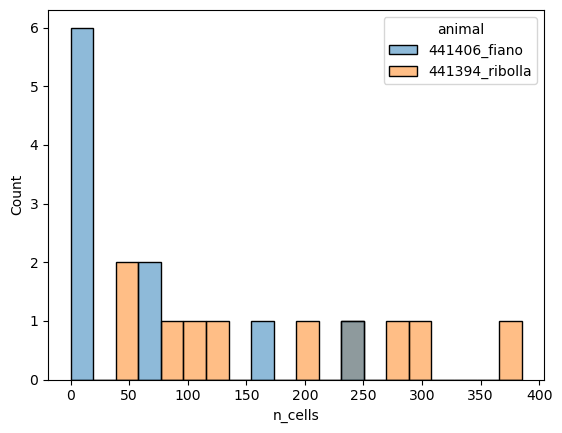

In [6]:
import seaborn as sns
sns.histplot(data=df,x='n_cells',hue='animal',bins=20)

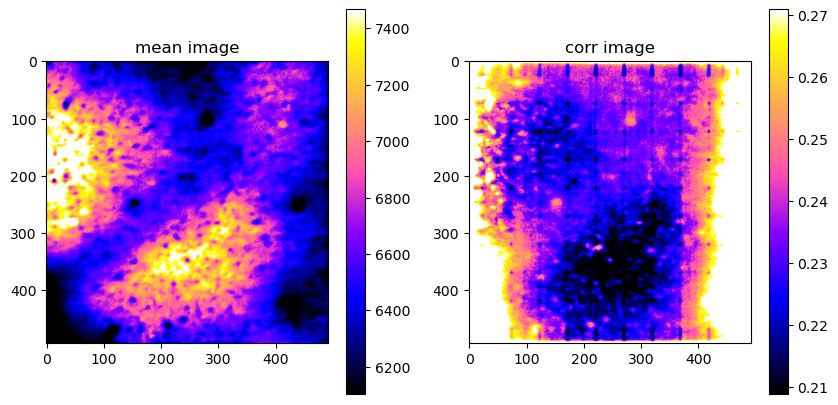

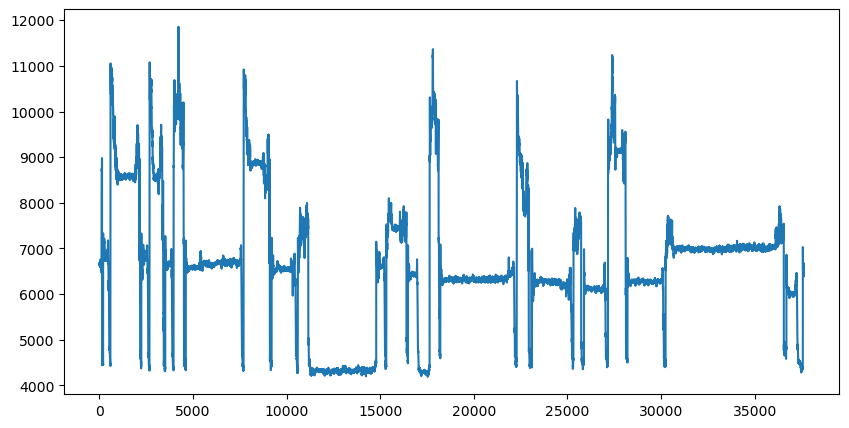

In [7]:
animal = '441406_fiano'
session = '20230307'
plot_session_metrics(animal,session)

## Luminance corrected

In [8]:
data_path = Path("/ceph/imaging1/davide/2p_data/eq_luminance")

# SESSION TO PREPROCESS
sessions = {'441406_fiano':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321'],
            '441394_ribolla':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321']
           }


In [9]:
df = {'animal':[],'date':[],'n_cells':[]}

for animal in sessions.keys():
    for date in sessions[animal]:
        with open(data_path.joinpath(f'{animal}/{date}/neural_data.pickle'),'rb') as pfile:
            data = pickle.load(pfile)
            df['animal'].append(animal)
            df['date'].append(date)
            df['n_cells'].append(len(data['traces']))

df = pd.DataFrame.from_dict(df) 

<Axes: xlabel='n_cells', ylabel='Count'>

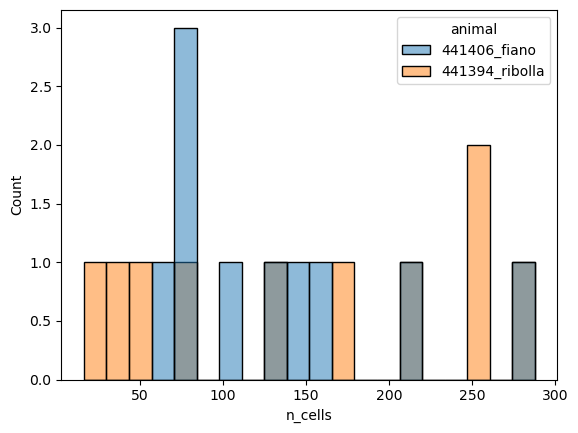

In [10]:
import seaborn as sns
sns.histplot(data=df,x='n_cells',hue='animal',bins=20)

In [11]:
df

,animal,date,n_cells
0,441406_fiano,20230301,78
1,441406_fiano,20230306,73
2,441406_fiano,20230307,163
3,441406_fiano,20230308,111
4,441406_fiano,20230309,288
5,441406_fiano,20230315,211
6,441406_fiano,20230316,75
7,441406_fiano,20230317,138
8,441406_fiano,20230320,57
9,441406_fiano,20230321,148
